In [3]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Transform and write out data according to stat_transforms.md

Steps:
1. log transform
2. decide on clipping method for low volume 3pt shooters
3. clip shooting outliers
4. write out data

In [4]:
df = pd.read_csv('data/data_clean.csv', index_col=0)
df.head()

,%3PA,%3PM,%AST,%BLK,%BLKA,%DREB,%FGA,%FGA 2PT,%FGA 3PT,%FGM,...,PTS,REB,REB%,STL,TO RATIO,TOT MIN,TOV,TS%,USG%,MPG
A.C. Green 1996,2.6,0.4,6.8,8.4,15.5,29.9,11.8,95.9,4.1,13.3,...,12.7,14.0,13.5,1.5,10.3,2494.0,1.6,52.3,11.8,30.048193
Aaron McKie 1996,16.6,19.6,25.2,12.4,22.6,17.7,14.4,71.8,28.2,13.2,...,14.0,7.2,7.1,2.5,13.5,1624.0,2.9,52.4,14.2,19.566265
Adam Keefe 1996,0.5,0.0,6.7,16.9,16.5,24.4,11.3,99.4,0.6,11.6,...,13.3,12.2,12.9,1.7,15.9,917.0,2.5,57.2,12.4,14.790323
Allan Houston 1996,44.7,45.0,14.6,6.7,19.6,11.6,24.5,62.8,37.2,22.3,...,23.2,4.6,4.8,0.8,11.4,2681.0,3.2,53.1,21.8,33.098765
Allen Iverson 1996,42.8,45.7,42.2,7.6,26.5,11.0,27.9,69.7,30.3,26.1,...,28.5,5.0,4.9,2.5,12.7,3041.0,5.4,51.3,28.1,40.013158


In [5]:
## cols to log transform based on distribution plots

log_cols = ['%3PA',
            '%3PM',
            '%AST',
            '%BLK',
            '%DREB',
            '%FGA 3PT',
            '%OREB',
            '%PF',
            '%PTS 3PT',
            '%REB',
            '%TOV',
            '3FGM %UAST',
            '3PA',
            '3PM',
            'AST',
            'AST RATIO',
            'AST%',
            'AST/TO',
            'BLK',
            'BLKA',
            'DREB',
            'DREB%',
            'FBPS',
            'FG%',
            'FGM',
            'FTA',
            'FTM',
            'OREB',
            'OREB%',
            'PF',
            'REB',
            'REB%',
            'STL',
            'TO RATIO',
            'TOV',]
len(log_cols)

35

In [8]:
df_trans = df.copy()
df_trans.loc[:, log_cols] = df_trans[log_cols].apply(np.log1p)
df_trans[log_cols]

,%3PA,%3PM,%AST,%BLK,%DREB,%FGA 3PT,%OREB,%PF,%PTS 3PT,%REB,...,FTA,FTM,OREB,OREB%,PF,REB,REB%,STL,TO RATIO,TOV
A.C. Green 1996,1.280934,0.336472,2.054124,2.240710,3.430756,1.629241,3.552487,2.760010,0.405465,3.468856,...,1.648659,1.308333,1.740466,2.292535,1.410987,2.708050,2.674149,0.916291,2.424803,0.955511
Aaron McKie 1996,2.867899,3.025291,3.265759,2.595255,2.928524,3.374169,2.415914,2.906901,3.380995,2.815409,...,1.526056,1.386294,0.832909,1.280934,1.648659,2.104134,2.091864,1.252763,2.674149,1.360977
Adam Keefe 1996,0.405465,0.000000,2.041220,2.884801,3.234749,0.470004,3.597312,3.054001,0.000000,3.346389,...,1.916923,1.609438,1.648659,2.360854,1.871802,2.580217,2.631889,0.993252,2.827314,1.252763
Allan Houston 1996,3.822098,3.828641,2.747271,2.041220,2.533697,3.642836,2.054124,2.923162,3.640214,2.424803,...,1.648659,1.481605,0.587787,1.029619,1.704748,1.722767,1.757858,0.587787,2.517696,1.435085
Allen Iverson 1996,3.779634,3.843744,3.765840,2.151762,2.484907,3.443618,2.509599,2.901422,3.295837,2.493205,...,2.272126,1.960095,1.029619,1.504077,1.547563,1.791759,1.774952,1.252763,2.617396,1.856298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Will Barton 2019,3.226844,3.265759,3.044522,2.827314,3.122365,3.688879,2.912351,2.850707,3.640214,3.077312,...,1.481605,1.280934,1.064711,1.609438,1.410987,2.332144,2.341806,0.955511,2.197225,1.163151
Willie Cauley-Stein 2019,0.182322,0.000000,2.587764,3.869116,3.414443,0.262364,3.737670,3.380995,0.000000,3.490429,...,1.360977,0.993252,1.547563,2.104134,1.840550,2.687847,2.681022,1.131402,2.312535,0.993252
Wilson Chandler 2019,3.144152,3.063391,2.564949,2.939162,3.182212,4.206184,2.116256,3.277145,4.009150,3.039749,...,0.916291,0.832909,0.530628,0.875469,1.808289,2.332144,2.312535,0.693147,2.624669,1.163151
Zach LaVine 2019,3.505557,3.577948,3.273364,2.901422,2.954910,3.723281,2.332144,2.727853,3.613617,2.833213,...,2.151762,1.960095,0.641854,1.064711,1.386294,2.028148,2.079442,1.098612,2.525729,1.740466


## investigate clipping very low volumne 3pt shooters

Thoughts:
- thinking of dropping all players with less than 0.75 3pa to 0 for '3FGM %UAST' as there is just no use in identifying these players AT ALL as 3 point creaters
- replace v noisy 3pt% for all player with less than 1 3pa (100 possessions) with mean for their number of attemps? (will this be noisy)
- the means i'm thinking of imputing with are themselves noisy as they are pulled by the massive outliers... i guess there arent that many
  - can use the median
    - medians are too overweight to 0, will use mean ... if someone HAS made at least SOME shots i don't want to overpenalize them.

Conclusions:
- The adjustment is based on 3PA
- if over 35% I will replace with mean for group comprised of same 3PA +/- 0.1
- is there a faster way to do this?

In [12]:
## all together here (see below for process)

## Transforming non 3-pt shooter outliers
df_non_3 = df.copy()
cols3 = ['3PA', '3P%', '3FGM %UAST']
# these are the cols I want to transform:
# ---> df_non_3.loc[(df_non_3['3PA'] < 1) & ((df_non_3['3P%'] > 35) | (df_non_3['3FGM %UAST'] > 35))]

# get means to impute with
vals = [i/10 for i in range(10)]
means_3percent = [0]
means_unassisted = [0]

for n in vals[1:]:
    shooting_percent_mean = df[(df['3PA'] >= (n - 0.1)) & (df['3PA'] <= (n + 0.1))]['3P%'].mean()
    means_3percent.append(shooting_percent_mean)
    unassisted_mean = df[(df['3PA'] >= (n - 0.1)) & (df['3PA'] <= (n + 0.1))]['3FGM %UAST'].mean()
    means_unassisted.append(unassisted_mean)

## mapping dicts
percent_dict = dict(zip(vals, means_3percent))
unassisted_dict = dict(zip(vals, means_unassisted))


# make transform
df_non_3.loc[(df_non_3['3PA'] < 1) & (df_non_3['3P%'] > 35), ['3P%']] = df_non_3.loc[(df_non_3['3PA'] < 1) & (df_non_3['3P%'] > 35)]['3PA'].map(percent_dict)
df_non_3.loc[(df_non_3['3PA'] < 1) & (df_non_3['3FGM %UAST'] > 35), ['3FGM %UAST']] = df_non_3.loc[(df_non_3['3PA'] < 1) & (df_non_3['3FGM %UAST'] > 35)]['3PA'].map(unassisted_dict)

## Combine shooting transform with log ... Save

In [32]:
df_trans = df.copy()
df_trans.loc[:, log_cols] = df_trans[log_cols].apply(np.log1p)
df_trans.loc[:, cols3] = df_non_3[cols3]
df_trans.to_csv('data/data_transformed.csv')

# WORKSHEET BELOW

In [13]:
# test... expect 0 rows:
df_non_3.loc[(df_non_3['3PA'] < 1) & ((df_non_3['3P%'] > 35) | (df_non_3['3FGM %UAST'] > 35))]

,%3PA,%3PM,%AST,%BLK,%BLKA,%DREB,%FGA,%FGA 2PT,%FGA 3PT,%FGM,...,PTS,REB,REB%,STL,TO RATIO,TOT MIN,TOV,TS%,USG%,MPG


In [27]:
## now to check that right vals were transformed
df.loc[(df['3PA'] < 1) & ((df['3P%'] > 35) | (df['3FGM %UAST'] > 35))][cols3][0:20]
idx = df.loc[(df['3PA'] < 1) & ((df['3P%'] > 35) | (df['3FGM %UAST'] > 35))][cols3].index[0:20]

df_non_3.loc[idx, cols3]

,3PA,3P%,3FGM %UAST
A.C. Green 1996,0.4,5.0,100.0
Anthony Mason 1996,0.1,33.3,100.0
Bryant Reeves 1996,0.2,9.1,100.0
Corie Blount 1996,0.2,33.3,100.0
Erick Dampier 1996,0.0,100.0,0.0
Greg Foster 1996,0.2,66.7,0.0
Joe Kleine 1996,0.2,66.7,0.0
John Wallace 1996,0.3,50.0,0.0
Kevin Willis 1996,0.4,14.3,100.0
Loren Meyer 1996,0.5,57.1,25.0


,3PA,3P%,3FGM %UAST
A.C. Green 1996,0.4,5.000000,14.063874
Anthony Mason 1996,0.1,33.300000,3.503600
Bryant Reeves 1996,0.2,9.100000,7.247156
Corie Blount 1996,0.2,33.300000,7.247156
Erick Dampier 1996,0.0,0.000000,0.000000
Greg Foster 1996,0.2,12.159979,0.000000
Joe Kleine 1996,0.2,12.159979,0.000000
John Wallace 1996,0.3,16.616973,0.000000
Kevin Willis 1996,0.4,14.300000,14.063874
Loren Meyer 1996,0.5,21.977255,25.000000


In [198]:
df_non_3 = df.copy()

print(df_non_3.loc[(df_non_3['3PA'] < 1) & (df_non_3['3P%'] > 35), ['3P%']].head())
df_non_3.loc[(df_non_3['3PA'] < 1) & (df_non_3['3P%'] > 35), ['3FMG %UAST']] = df_non_3.loc[(df_non_3['3PA'] < 1) & (df_non_3['3P%'] > 35)]['3PA'].map(unassisted_dict)

print()

print(df_non_3.loc[(df_non_3['3PA'] < 1) & (df_non_3['3P%'] > 35), ['3P%']].head())

                      3P%
Erick Dampier 1996  100.0
Greg Foster 1996     66.7
Joe Kleine 1996      66.7
John Wallace 1996    50.0
Loren Meyer 1996     57.1

                      3P%
Erick Dampier 1996  100.0
Greg Foster 1996     66.7
Joe Kleine 1996      66.7
John Wallace 1996    50.0
Loren Meyer 1996     57.1


In [197]:
df_non_3 = df.copy()

print(df_non_3.loc[(df_non_3['3PA'] < 1) & (df_non_3['3P%'] > 35), ['3P%']].head())
df_non_3.loc[(df_non_3['3PA'] < 1) & (df_non_3['3P%'] > 35), ['3P%']] = df_non_3.loc[(df_non_3['3PA'] < 1) & (df_non_3['3P%'] > 35)]['3PA'].map(percent_dict)

print()

print(df_non_3.loc[(df_non_3['3PA'] < 1) & (df_non_3['3P%'] > 35), ['3P%']].head())


                      3P%
Erick Dampier 1996  100.0
Greg Foster 1996     66.7
Joe Kleine 1996      66.7
John Wallace 1996    50.0
Loren Meyer 1996     57.1

Empty DataFrame
Columns: [3P%]
Index: []


In [188]:
unassisted_dict

{0.0: 0,
 0.1: 3.503600464576074,
 0.2: 7.247156153050672,
 0.3: 12.365235173824132,
 0.4: 14.063874345549737,
 0.5: 14.029019607843138,
 0.6: 12.996534653465348,
 0.7: 14.499999999999998,
 0.8: 12.230188679245284,
 0.9: 11.40328947368421}

In [202]:
df_non_3.loc[(df_non_3['3PA'] < 1) & ((df_non_3['3P%'] > 35) | (df_non_3['3FGM %UAST'] > 35))]

,%3PA,%3PM,%AST,%BLK,%BLKA,%DREB,%FGA,%FGA 2PT,%FGA 3PT,%FGM,...,PTS,REB,REB%,STL,TO RATIO,TOT MIN,TOV,TS%,USG%,MPG


In [167]:
## Transforming non 3-pt shooter outliers

df_non_3 = df.copy()
# these are the cols I want to transform
df_non_3.loc[(df_non_3['3PA'] < 1) & ((df_non_3['3P%'] > 35) | (df_non_3['3FGM %UAST'] > 35))][cols3]

# create dict map of mean values
vals = [i/10 for i in range(10)]
means_3percent = [0]
means_unassisted = [0]

for n in vals[1:]:
    shooting_percent_mean = df[(df['3PA'] >= (n - 0.1)) & (df['3PA'] <= (n + 0.1))]['3P%'].mean()
    means_3percent.append(shooting_percent_mean)
    unassisted_mean = df[(df['3PA'] >= (n - 0.1)) & (df['3PA'] <= (n + 0.1))]['3FGM %UAST'].mean()
    means_unassisted.append(unassisted_mean)

In [168]:
vals

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [169]:
## mapping dicts

percent_dict = dict(zip(vals, means_3percent))
unassisted_dict = dict(zip(vals, means_unassisted))
unassisted_dict

{0.0: 0,
 0.1: 3.503600464576074,
 0.2: 7.247156153050672,
 0.3: 12.365235173824132,
 0.4: 14.063874345549737,
 0.5: 14.029019607843138,
 0.6: 12.996534653465348,
 0.7: 14.499999999999998,
 0.8: 12.230188679245284,
 0.9: 11.40328947368421}

In [178]:
df_test = df.copy()

df_test.loc[(df_non_3['3PA'] < 1) & (df_non_3['3P%'] > 35), ['3P%']] = df_test.loc[(df_non_3['3PA'] < 1) & (df_non_3['3P%'] > 35)]['3PA'].map(percent_dict)

# df_non_3.loc[(df_non_3['3PA'] < 1) & (df_non_3['3P%'] > 35)]['3P%'].map(percent_dict)

,3P%
Erick Dampier 1996,0.000000
Greg Foster 1996,12.159979
Joe Kleine 1996,12.159979
John Wallace 1996,16.616973
Loren Meyer 1996,21.977255
...,...
Dwight Howard 2019,12.159979
Hassan Whiteside 2019,12.159979
JaVale McGee 2019,16.616973
Tristan Thompson 2019,22.443069


In [173]:
df_non_3.loc[(df_non_3['3PA'] < 1) & (df_non_3['3P%'] > 35)]['3P%']

Erick Dampier 1996       100.0
Greg Foster 1996          66.7
Joe Kleine 1996           66.7
John Wallace 1996         50.0
Loren Meyer 1996          57.1
                         ...  
Dwight Howard 2019        60.0
Hassan Whiteside 2019     57.1
JaVale McGee 2019         50.0
Tristan Thompson 2019     39.1
Zion Williamson 2019      42.9
Name: 3P%, Length: 168, dtype: float64

In [151]:
# check transformed values against this
df_non_3.loc[(df_non_3['3PA'] < 1) & ((df_non_3['3P%'] > 35) | (df_non_3['3FGM %UAST'] > 35))][cols3][0:50]

,3PA,3P%,3FGM %UAST
A.C. Green 1996,0.4,5.0,100.0
Anthony Mason 1996,0.1,33.3,100.0
Bryant Reeves 1996,0.2,9.1,100.0
Corie Blount 1996,0.2,33.3,100.0
Erick Dampier 1996,0.0,100.0,0.0
Greg Foster 1996,0.2,66.7,0.0
Joe Kleine 1996,0.2,66.7,0.0
John Wallace 1996,0.3,50.0,0.0
Kevin Willis 1996,0.4,14.3,100.0
Loren Meyer 1996,0.5,57.1,25.0


In [140]:
## checking mean calculations
print(means_3percent)
print('\n\n')
print(means_unassisted)

# check out (see below, and just double checked the logic i made them with)

[6.784378629500581, 12.159979317476733, 16.61697341513292, 21.273821989528795, 21.977254901960784, 22.443069306930692, 22.38983050847457, 24.91037735849057, 24.93421052631579]



[3.503600464576074, 7.247156153050672, 12.365235173824132, 14.063874345549737, 14.029019607843138, 12.996534653465348, 14.499999999999998, 12.230188679245284, 11.40328947368421]


In [38]:
## how many problem rows?

for col in ['3FGM %UAST', '3P%']:
    print(col + ':', len(df[df[col]==100]), 'rows with 100%')

3FGM %UAST: 72 rows with 100%
3P%: 31 rows with 100%


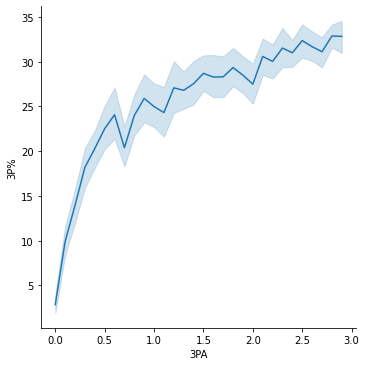

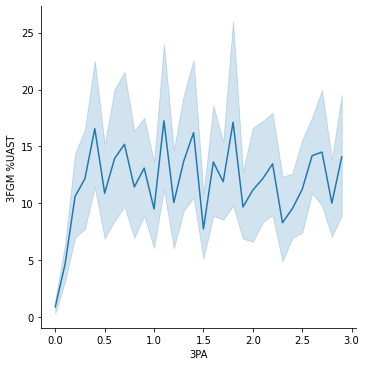

In [76]:
### plot shooting % stats

df_non_3 = df[df['3PA'] < 3].copy()
sns.relplot(x='3PA', y='3P%', data=df_non_3, kind='line')
sns.relplot(x='3PA', y='3FGM %UAST', data=df_non_3, kind='line')

In [136]:
## seeing counts for each group 0-1 of 3pa +/- 0.1

vals = [i/10 for i in range(1,11)]
for n in vals:
    print(str(n) + ':', df[(df['3PA'] >= (n - 0.1)) & (df['3PA'] <= (n + 0.1))].shape)
    print('\nmedians:')
    print(df[(df['3PA'] >= (n - 0.1)) & (df['3PA'] <= (n + 0.1))][['3P%', '3FGM %UAST']].median())
    print('\nmeans:')
    print(df[(df['3PA'] >= (n - 0.1)) & (df['3PA'] <= (n + 0.1))][['3P%', '3FGM %UAST']].mean())
    print('\n---------\n')

0.1: (1722, 66)

medians:
3P%           0.0
3FGM %UAST    0.0
dtype: float64

means:
3P%           6.784379
3FGM %UAST    3.503600
dtype: float64

---------

0.2: (967, 66)

medians:
3P%           0.0
3FGM %UAST    0.0
dtype: float64

means:
3P%           12.159979
3FGM %UAST     7.247156
dtype: float64

---------

0.3: (489, 66)

medians:
3P%           16.7
3FGM %UAST     0.0
dtype: float64

means:
3P%           16.616973
3FGM %UAST    12.365235
dtype: float64

---------

0.4: (191, 66)

medians:
3P%           21.4
3FGM %UAST     0.0
dtype: float64

means:
3P%           21.273822
3FGM %UAST    14.063874
dtype: float64

---------

0.5: (255, 66)

medians:
3P%           22.2
3FGM %UAST     0.0
dtype: float64

means:
3P%           21.977255
3FGM %UAST    14.029020
dtype: float64

---------

0.6: (202, 66)

medians:
3P%           23.1
3FGM %UAST     0.0
dtype: float64

means:
3P%           22.443069
3FGM %UAST    12.996535
dtype: float64

---------

0.7: (118, 66)

medians:
3P%           

In [117]:
## are there any outliers who shoot more than 1 3pa?

print(len(df[(df['3PA'] >= 1) & (df['3P%'] >= 555)]))  ## 0!
print(len(df[(df['3PA'] >= 1) & (df['3FGM %UAST'] >= 50)]))  ## 152 ... these are ok outliers... generally shot creaters 
print(len(df[(df['3PA'] >= 1) & (df['3FGM %UAST'] >= 55)]))  ## 79
print(len(df[(df['3PA'] >= 1) & (df['3FGM %UAST'] >= 60)]))  ## 46
print(len(df[(df['3PA'] >= 1) & (df['3FGM %UAST'] >= 80)]))  ## 4

0
152
79
46
4
                   %3PA  %3PM  %AST  %BLK  %BLKA  %DREB  %FGA  %FGA 2PT  \
Dwyane Wade 2011   13.2   9.7  31.3  30.1   19.9   15.1  31.2      93.3   
Ish Smith 2013      4.9   0.6  43.9  14.6   21.1   15.5  16.1      91.8   
James Harden 2018  38.7  39.5  48.2  20.1   41.2   24.4  37.4      46.1   
James Harden 2019  36.1  36.8  46.4  21.6   34.8   20.9  33.0      44.3   

                   %FGA 3PT  %FGM  ...   PTS  REB  REB%  STL  TO RATIO  \
Dwyane Wade 2011        6.7  31.7  ...  34.0  7.4   7.6  2.6       9.8   
Ish Smith 2013          8.2  15.5  ...  12.8  6.3   6.4  2.4      12.0   
James Harden 2018      53.9  36.2  ...  48.2  8.9   8.9  2.7      12.0   
James Harden 2019      55.7  32.5  ...  43.9  8.4   8.3  2.4      11.6   

                   TOT MIN  TOV   TS%  USG%        MPG  
Dwyane Wade 2011    1625.0  4.1  55.9  30.5  33.163265  
Ish Smith 2013      1006.0  3.2  43.8  15.5  14.371429  
James Harden 2018   2867.0  6.6  61.6  39.6  36.756410  
James Harde

In [99]:

cols3 = ['3PA', '3P%', '3FGM %UAST']
df[(df['3FGM %UAST'] >= 75) & (df['3PA'] > 0.5) & (df['3PA'] < 1.5)][cols3]

,3PA,3P%,3FGM %UAST
Carlos Rogers 1999,0.6,7.1,100.0
Rod Strickland 2000,0.6,23.5,75.0
Milt Palacio 2005,0.6,6.3,100.0
Bonzi Wells 2006,0.6,14.3,100.0
Brevin Knight 2006,0.7,5.6,100.0
Ish Smith 2013,1.1,4.3,100.0


In [95]:
df[(df['3P%'] >= 50) & (df['3PA'] > 1.5)]

,%3PA,%3PM,%AST,%BLK,%BLKA,%DREB,%FGA,%FGA 2PT,%FGA 3PT,%FGM,...,PTS,REB,REB%,STL,TO RATIO,TOT MIN,TOV,TS%,USG%,MPG
Shandon Anderson 1996,21.5,28.2,8.8,7.1,32.3,19.6,19.6,85.2,14.8,18.1,...,19.3,8.9,9.4,1.3,15.1,1067.0,3.6,53.4,19.0,16.415385
Jason Kapono 2006,32.7,45.2,10.9,1.0,9.9,13.6,20.1,62.7,37.3,21.3,...,21.5,5.3,5.3,1.1,9.4,1767.0,2.1,61.3,17.4,26.373134
Kyle Korver 2009,32.2,44.0,16.3,11.9,4.8,15.3,17.6,60.7,39.3,17.5,...,19.5,5.8,6.1,1.4,9.9,952.0,2.2,62.0,15.4,18.307692
Luke Babbitt 2014,32.9,45.0,6.5,11.2,10.3,17.6,13.7,40.1,59.9,14.4,...,15.5,6.7,6.7,1.0,10.4,830.0,1.6,63.9,12.2,13.174603
Pau Gasol 2016,13.3,17.6,18.0,36.1,30.1,35.2,21.4,82.8,17.2,22.4,...,24.5,15.5,15.9,0.7,8.8,1627.0,2.5,57.8,21.3,25.421875


In [30]:
df[['3FGM %UAST', '3P%','3PA']].sort_values(by='3FGM %UAST', ascending=False)[0:50]

,3FGM %UAST,3P%,3PA
A.C. Green 1996,100.0,5.0,0.4
Elden Campbell 1997,100.0,50.0,0.1
Shawn Bradley 1999,100.0,20.0,0.1
Maurice Taylor 1999,100.0,12.5,0.2
Tom Gugliotta 2003,100.0,25.0,0.3
Malik Rose 1999,100.0,33.3,0.1
DJ White 2011,100.0,100.0,0.0
Keon Clark 1999,100.0,12.5,0.2
Joe Smith 1999,100.0,100.0,0.0
Taj Gibson 2010,100.0,12.5,0.2


In [29]:
df[df['3PA'] < 1]['3P%'].describe()

# df[df['3PA'] < 0.5]['3P%'].describe()

count    1975.000000
mean        8.361418
std        17.687590
min         0.000000
25%         0.000000
50%         0.000000
75%        11.100000
max       100.000000
Name: 3P%, dtype: float64

In [25]:
df[['3P%', '3PA']].sort_values(by='3P%', ascending=False)[0:50]

## Can push to 0 or can assign everyone under 1 3pa to the mean 

,3P%,3PA
Joe Smith 1999,100.0,0.0
Johnny O'Bryant III 2015,100.0,0.1
Marc Jackson 2002,100.0,0.0
Hassan Whiteside 2017,100.0,0.1
Eddy Curry 2006,100.0,0.0
Kurt Thomas 2010,100.0,0.0
Marcin Gortat 2008,100.0,0.1
Roy Rogers 1996,100.0,0.0
Malik Rose 2005,100.0,0.0
DJ White 2011,100.0,0.0
